In [1]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os

from tqdm import tqdm
import csv
import pandas as pd
import polars as pl
import sys
import ultralytics
from ultralytics import YOLO
import json

sys.path.append('..')
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "frameworks", "dtag"))

from datetime import datetime

dtag_rep_pth = os.path.dirname(os.getcwd())
dtag_rep_pth = os.path.join(dtag_rep_pth, 'frameworks', "dtag")

from support.pd_support import *
from support.ar_calculations import *

from scipy.signal import savgol_filter
from scipy import integrate
# from ahrs.filters import Madgwick

In [2]:
ultralytics.checks()

Ultralytics YOLOv8.0.150  Python-3.11.4 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Setup complete  (24 CPUs, 15.7 GB RAM, 65.2/280.0 GB disk)


In [3]:
from deeptag_model_setting import load_deeptag_models
from marker_dict_setting import load_marker_codebook
from stag_decode.detection_engine import DetectionEngine 

In [4]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "validation"
_calib_folder_name = "calibration_00"

_folder_name = "ar_30_5_quad_random_00"
# _folder_name = "sk_30_4_random_00"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

_webcam_8_point_pth = os.path.join(_webcam_calib_folder, "8p_dist_calib.msgpack")


with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]
    
with open(_webcam_8_point_pth, "rb") as f:
    webcam_8_point = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_8_point)
    _webcam_8_point_mat = _temp[0]
    _webcam_8_point_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "webcam_rotmat_0.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)


config_filename = f'{dtag_rep_pth}\\config_video.json'
config_dict = json.load(open(config_filename, 'r'))
# cameraMatrix = _webcam_8_point_mat[0]
cameraMatrix = _webcam_cam_mat.reshape(1,9)[0]
# distCoeffs = _webcam_8_point_dist[0][:8]
distCoeffs = _webcam_dist[0]
tag_real_size_in_meter = 0.04
is_video = config_dict['is_video']!=0
filename = config_dict['filepath']
tag_family = config_dict['family']
codebook_filename  = config_dict['codebook'] if len(config_dict['codebook']) else os.path.join('codebook', tag_family + '_codebook.txt')
hamming_dist = config_dict['hamming_dist']
load_config_flag = True

In [5]:
# timestamp
ts = []
ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
ts_file = open(ts_pth, "rb")
ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
for ts_data in ts_unpacker:
    ts.append(datetime.strptime(ts_data, "%Y-%m-%d %H:%M:%S.%f"))

In [6]:
_imu_pth = os.path.join(_base_pth, _folder_name, "imu01.csv")
_imu_df = pl.read_csv(_imu_pth)
timeoffset = 0.0

dt = _imu_df["mils"].diff().mean()/1000
dt = 0.01
filter_size = 101
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size ].mean()
_mean_gy = _imu_df["gy"][:filter_size ].mean()
_mean_gz = _imu_df["gz"][:filter_size ].mean()
_mean_ax = _imu_df["ax"][:filter_size ].mean()
_mean_ay = _imu_df["ay"][:filter_size ].mean()
_mean_az = _imu_df["az"][:filter_size ].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns([
    (pl.col("gx") - _mean_gx).alias("gx"),
    (pl.col("gy") - _mean_gy).alias("gy"),
    (pl.col("gz") - _mean_gz).alias("gz"),
])

# subtracting mean from accel
_imu_df = _imu_df.with_columns([
    (pl.col("ax") - _mean_ax).alias("ax"),
    (pl.col("ay") - _mean_ay).alias("ay"),
    (pl.col("az") - _mean_az).alias("az"),
])

# apply savgol filter
_imu_df = _imu_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("az").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                    ])


_imu_df = _imu_df.with_columns([
                (pl.col("gx").cumsum()*dt * 9.81).alias("ang_x"),
                (pl.col("gy").cumsum()*dt * 9.81).alias("ang_y"),
                (pl.col("gz").cumsum()*dt * 9.81).alias("ang_z"),
            ])

_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("time"))
_imu_df = _imu_df.with_columns(pl.col("time").map(lambda x: x + timedelta(seconds=timeoffset)).alias("time"))

#change string to float
_imu_df = _imu_df.with_columns(pl.col("mz\r").str.replace("\r","").cast(pl.Float64).alias("mz"))

In [7]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = int(_folder_name.split("_")[2])/100
markerSeperation = 0.01

board = aruco.GridBoard(
        size= [1,1],
        markerLength=markerLength,
        markerSeparation=markerSeperation,
        dictionary=ARUCO_DICT)

In [8]:
marker_size = markerLength

marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                            [marker_size / 2, marker_size / 2, 0],
                            [marker_size / 2, -marker_size / 2, 0],
                            [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)

In [9]:
def my_estimatePoseSingleMarkers(corners, marker_points, mtx, distortion):
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, False, flags= cv2.SOLVEPNP_ITERATIVE)
        rvecs.append(R)
        tvecs.append(t)
        trash.append(nada)
    return rvecs, tvecs, trash

In [42]:
model_pth = os.path.join(os.getcwd(), "..",'models_save', 'mip_p2_60e_noise.pt')
# model_pth = os.path.join(os.getcwd(), "..",'models_save', 'best.pt')
yolo_model = YOLO(model_pth)
# model_pth

In [43]:
load_model_flag = False
try:
    model_detector, model_decoder, device, tag_type, grid_size_cand_list = load_deeptag_models(tag_family, None) 
    load_model_flag = True
except:
    print('Cannot load models.')
    
# load marker library
load_codebook_flag = False
try:
    codebook = load_marker_codebook(os.path.join(dtag_rep_pth, codebook_filename), tag_type)
    load_codebook_flag = True
except:
    print('Cannot load codebook: %s'% codebook_filename)
    
stag_image_processor = DetectionEngine(model_detector, model_decoder, device, tag_type, grid_size_cand_list, 
            stg2_iter_num= 2, # 1 or 2
            min_center_score=0.2, min_corner_score = 0.2, # 0.1 or 0.2 or 0.3
            batch_size_stg2 = 4, # 1 or 2 or 4
            hamming_dist= hamming_dist, # 0, 2, 4
            cameraMatrix = cameraMatrix, distCoeffs=  distCoeffs, codebook = codebook,
            tag_real_size_in_meter_dict = {-1:tag_real_size_in_meter})

===========> loading model <===========


In [44]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

aruco_std = {"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}
yolo_xyz = {"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}
dtag_xyz = {"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}

missing_counter = []
counter = 0


for _frame in tqdm(_video_data):

    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
    corners, ids, rejected_image_points = detector.detectMarkers(gray)
    corners, ids, rejectedpoints,_ = detector.refineDetectedMarkers(image=gray,board=board ,detectedCorners=corners, detectedIds=ids, rejectedCorners=rejected_image_points, cameraMatrix=_webcam_cam_mat, distCoeffs=_webcam_dist)
    rvec, tvec,_  = my_estimatePoseSingleMarkers(corners, marker_points, _webcam_cam_mat, _webcam_dist)
    if ids is not None:
    
        aruco_std["x"].append(tvec[0][0][0])
        aruco_std["y"].append(tvec[0][1][0])
        aruco_std["z"].append(tvec[0][2][0])
        aruco_std["rx"].append(rvec[0][0][0])
        aruco_std["ry"].append(rvec[0][1][0])
        aruco_std["rz"].append(rvec[0][2][0])
    else:
        aruco_std["x"].append(np.nan)
        aruco_std["y"].append(np.nan)
        aruco_std["z"].append(np.nan)
        aruco_std["rx"].append(np.nan)
        aruco_std["ry"].append(np.nan)
        aruco_std["rz"].append(np.nan)
        
    # YOLO
    
    yolo_results = yolo_model.predict(_frame, verbose=False)[0]
    modelcorners = []
    for _keys in yolo_results.keypoints.data:
        modelcorners.append(_keys[0:4].cpu().numpy())
    modelcorners = np.array(modelcorners)
    
    if len(yolo_results.boxes.cls.cpu().numpy()) != 0: # if there are any detections else None
        _idx = yolo_results.boxes.cls.cpu().numpy()
        ids = []
        for i in _idx:
            match i:
                case 0:
                    ids.append([12])
                case 1:
                    ids.append([88])
                case 2:
                    ids.append([89])
        ids = np.array(ids, dtype=np.int32)
    else:
        ids = None

    if len(modelcorners) != 0: # if there are any detections else skip

        try:
            y_rvec, y_tvec, _ = my_estimatePoseSingleMarkers(modelcorners, marker_points, _webcam_cam_mat, _webcam_dist)
        except:
            ids = None
    
    if ids is not None:
        yolo_xyz["x"].append(y_tvec[0][0][0])
        yolo_xyz["y"].append(y_tvec[0][1][0])
        yolo_xyz["z"].append(y_tvec[0][2][0])
        yolo_xyz["rx"].append(y_rvec[0][0][0])
        yolo_xyz["ry"].append(y_rvec[0][1][0])
        yolo_xyz["rz"].append(y_rvec[0][2][0])
    else:
        yolo_xyz["x"].append(np.nan)
        yolo_xyz["y"].append(np.nan)
        yolo_xyz["z"].append(np.nan)
        yolo_xyz["rx"].append(np.nan)
        yolo_xyz["ry"].append(np.nan)
        yolo_xyz["rz"].append(np.nan)
        missing_counter.append(counter)
        
    counter += 1
    # DTag
    
    decoded_tags = stag_image_processor.process(_frame, detect_scale=None)
    
    if len(decoded_tags)>0 and decoded_tags[0]["is_valid"]:
        dtag_xyz["x"].append(decoded_tags[0]["tvecs"][0][0])
        dtag_xyz["y"].append(decoded_tags[0]["tvecs"][1][0])
        dtag_xyz["z"].append(decoded_tags[0]["tvecs"][2][0])
        dtag_xyz["rx"].append(decoded_tags[0]["rvecs"][0][0])
        dtag_xyz["ry"].append(decoded_tags[0]["rvecs"][1][0])
        dtag_xyz["rz"].append(decoded_tags[0]["rvecs"][2][0])
        
    else:
        dtag_xyz["x"].append(np.nan)
        dtag_xyz["y"].append(np.nan)
        dtag_xyz["z"].append(np.nan)
        dtag_xyz["rx"].append(np.nan)
        dtag_xyz["ry"].append(np.nan)
        dtag_xyz["rz"].append(np.nan)
        # missing_counter.append(counter)
        

645it [00:59, 10.84it/s]


In [45]:
aruco_std["time"] = ts
yolo_xyz['time'] = ts
dtag_xyz['time'] = ts

In [46]:
def calculate_angle(df):
    
    rx = df['rx']
    ry = df['ry']
    rz = df['rz']
    
    # calculating rotation matrix
    rmat = []
    for i in tqdm(range(len(rx))):
        rmat.append(cv2.Rodrigues(np.array([rx[i], ry[i], rz[i]]))[0])
    
    _del_r_0 = []
    for i in tqdm(range(len(rmat))):
        _del_r_0.append(rmat[i].T@rmat[0])

    # calculating angle for mc
    _theta_x_0 = []
    _theta_y_0 = []
    _theta_z_0 = []

    for i in tqdm(_del_r_0):
        _theta_x_0.append(np.arctan2(i[2,1], i[2,2]))
        _theta_y_0.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
        _theta_z_0.append(np.arctan2(i[1,0], i[0,0]))
        
    _theta_x_0 = np.array(_theta_x_0)
    _theta_y_0 = np.array(_theta_y_0)
    _theta_z_0 = np.array(_theta_z_0)

    # converting them to degrees
    _theta_x_0 = np.rad2deg(_theta_x_0)
    _theta_y_0 = np.rad2deg(_theta_y_0)
    _theta_z_0 = np.rad2deg(_theta_z_0)
    
    return _theta_x_0, _theta_y_0, _theta_z_0

In [47]:
ar_df = pl.DataFrame(aruco_std)
yolo_df = pl.DataFrame(yolo_xyz)
dtag_df = pl.DataFrame(dtag_xyz)

In [48]:
_tx, _ty, _tz = calculate_angle(dtag_df)

100%|██████████| 645/645 [00:00<00:00, 214470.12it/s]


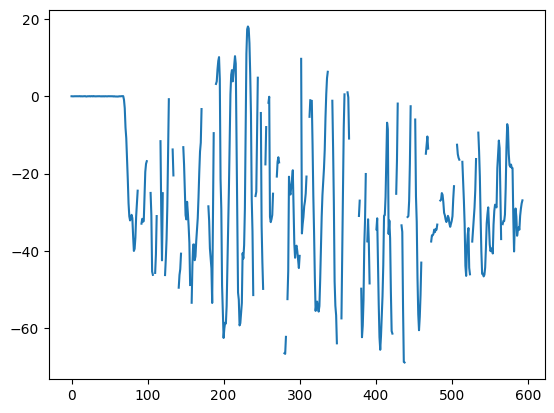

In [49]:
plt.plot(_ty)

In [50]:
_mocap_pth = os.path.join(os.path.dirname(os.path.dirname(_video_pth)), "validation", f"{_folder_name}.csv")
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
_mocap_df = pl.from_pandas(_mocap_df)

In [51]:
_tl = get_rb_marker_name(3)
_tr = get_rb_marker_name(1)
_bl = get_rb_marker_name(2)
_br = get_rb_marker_name(4)

# finding the center of the marker

_center_x = _mocap_df[[_tl["x"], _tr["x"], _bl["x"], _br["x"]]].mean(axis=1)/4
_center_y = _mocap_df[[_tl["y"], _tr["y"], _bl["y"], _br["y"]]].mean(axis=1)/4
_center_z = _mocap_df[[_tl["z"], _tr["z"], _bl["z"], _br["z"]]].mean(axis=1)/4

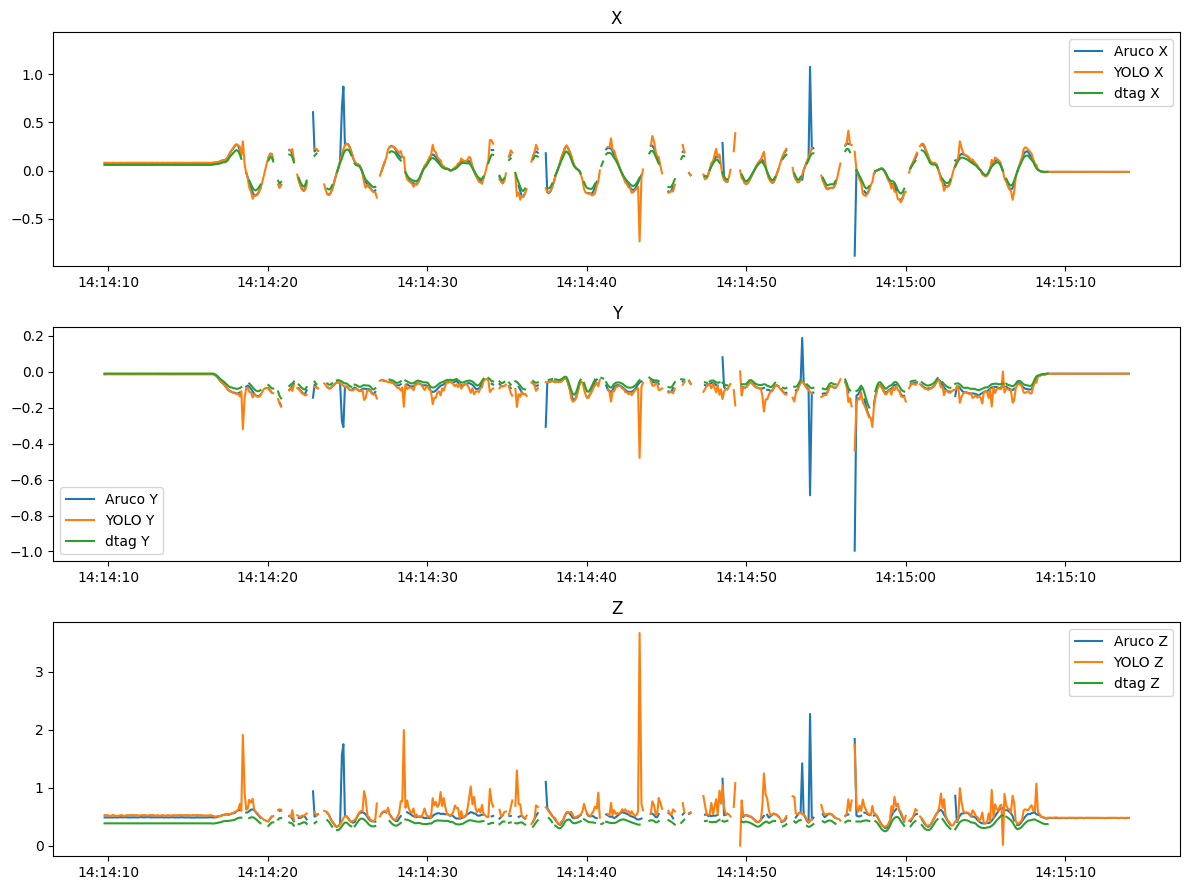

In [52]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9))

axs[0].plot(ts, aruco_std["x"], label='Aruco X')
axs[0].plot(ts, yolo_xyz["x"], label='YOLO X')
axs[0].plot(ts, dtag_xyz["x"], label='dtag X')
axs[0].set_title('X')
axs[0].legend()

axs[1].plot(ts, aruco_std["y"], label='Aruco Y')
axs[1].plot(ts, yolo_xyz["y"], label='YOLO Y')
axs[1].plot(ts, dtag_xyz["y"], label='dtag Y')
axs[1].set_title('Y')
axs[1].legend()

axs[2].plot(ts, aruco_std["z"], label='Aruco Z')
axs[2].plot(ts, yolo_xyz["z"], label='YOLO Z')
axs[2].plot(ts, dtag_xyz["z"], label='dtag Z')
axs[2].set_title('Z')
axs[2].legend()

# Add space between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [53]:
ar_df["x"].is_nan().sum() * 100 / len(ar_df)

19.53488372093023

In [54]:
yolo_df["x"].is_nan().sum() * 100 / len(ar_df)

9.922480620155039

In [55]:
dtag_df["x"].is_nan().sum() * 100 / len(dtag_df)

28.372093023255815

In [56]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

missing_counter = []
counter = 0

for idx, _frame in enumerate(tqdm(_video_data)):
    if idx == 201:
        break

201it [00:00, 271.74it/s]


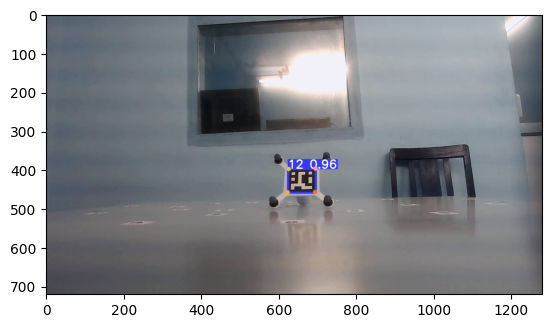

In [57]:
plt.imshow(yolo_results.plot())